# G$^2$Pnet: The Grassmanian Gaussian Process Network
We check the implementation of G2PnetSolver (ver 6.) with conjugate gradient descent class in ../src/

Created by Tianpei Xie, 04/13/2016

Last Edit 04/21/2016

In [1]:
%reset
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics.pairwise import rbf_kernel, pairwise_kernels
import GPy
import GPy.util as gutil

%matplotlib inline 
plt.close('all')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


/home/tianpei/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
Ifsavefig =  False
Ifsavedata = False
trial = 1

In [3]:
G=nx.read_adjlist("../data/04_01_2016_experiment0.adjlist")

size = 40
color_map = {0:'r', 1:'c', 2:'y'}
#center = np.zeros(2)
#center[1] = 1
center = None

n = 40
m = 0
G0= nx.barbell_graph(n,m) 
#generate the bar-bell graph, which consists of two fully connected component and a path connecting them 

label0 = np.zeros([2*n,1])
label0[n:2*n] = np.ones([n,1])
#### labeling of the cluster
for node in G0.nodes():
    G0.node[node]['category'] = int(label0[node,0])

In [4]:
data_df = pd.read_csv("../data/04_01_2016_experiment0_X.csv", index_col = 'ID')
spectral_df = pd.read_csv("../data/04_01_2016_experiment0_U.csv", index_col ='ID')
U_init_pd = pd.read_csv("../data/04_20_16_1_U_init.csv", index_col = 0)

In [5]:
X = data_df.loc[:,['0_cos','1_cos']].values
U = spectral_df.loc[:,['PX','PY']].values
labels = data_df.loc[:,'LABEL'].values
U_init = U_init_pd.loc[:,['0','1']].values

In [6]:
nsample, ndim = X.shape
_ , ndim_latent = U.shape

In [7]:
import sys
import os
dirorg = os.path.dirname(os.getcwd())
sys.path.insert(0, dirorg+"/src/")

In [8]:
import G2PnetSolver#G2PnetSolver_v2
#from imp import reload
#reload(G2PnetSolver_v2)

In [9]:
from G2PnetSolver import  G2PnetSolver as Solver
from G2PnetSolver import  Grassmann_update, check_step

In [10]:
choice = "near"
IfGen = False

In [11]:
if IfGen:
    np.random.seed(seed=150)

    if choice == "random":
        print("Random Initialization")
        Temp = np.random.randn(nsample, nsample)
        Temp_sym = (Temp + Temp.T) / 2 
        _, U_temp = np.linalg.eig(Temp_sym)
        U_test = U_temp[:, np.arange(ndim_latent)]
        U0 = U_test
    elif choice == "near":
        print("Initialization in neigborhood.")
        U0 = U

    ones = np.ones([nsample,])/np.sqrt(nsample)
    eta0 = 0.75
    np.random.seed(seed=220)
    G_temp = np.random.randn(nsample, ndim_latent) / (np.sqrt(nsample * ndim_latent))
    H_temp = -np.dot((np.eye(nsample) - gutil.linalg.tdot(np.column_stack((U0, ones)))),G_temp)
    print(str(check_step(H_temp, eta0)))

    while not check_step(H_temp, eta0):
        np.random.seed(seed=160)
        G_temp = np.random.randn(nsample, ndim_latent) / np.sqrt(nsample * ndim_latent)
        H_temp = -np.dot((np.eye(nsample) - gutil.linalg.tdot(np.column_stack((U0, ones)))),G_temp)
    U_init, dU = Grassmann_update(U0, H_temp, eta=eta0)
    np.linalg.norm(dU)

In [12]:
if Ifsavedata:
    U_columns = [str(i) for i in np.arange(ndim_latent)]
    U_df = pd.DataFrame(data = U_init, columns=U_columns, dtype= float)
    if choice == "random":
        U_df['RANDOM'] = np.ones([nsample, 1])
    elif choice == "near":
        U_df['RANDOM'] = np.zeros([nsample, 1])
    
    U_df.to_csv("../data/04_21_16_" + str(trial)  + "_U_init.csv")

In [13]:
add_reg = True
max_iters = 1000
#eta_array = np.array([1e-3, 2e-3, 5e-3])
#lambda_var = 1
eta = 3e-3
lambda_array = np.array([1]) 
array_temp = lambda_array#eta_array
stepsize_mode = "shrinkage"  #"fixed"

kern_array = [GPy.kern.RBF(2) + GPy.kern.White(2) for i in np.arange(len(array_temp))]
kern_grass_array = [GPy.kern.RBF(2)+ GPy.kern.White(2)  for i in np.arange(len(array_temp))]
kern_conjugate_grass_array = [GPy.kern.RBF(2)+ GPy.kern.White(2) for i in np.arange(len(array_temp))]
noise_interval = np.array([0.2,0.21])

In [14]:
solver_array = []
hist_nll_eu_array = []
hist_nll_grass_array = []
hist_nll_conjugate_grass_array = []
hist_Hsig_array = []
hist_Hsig_conjugate_array = []
hist_Gnorm_array = []
hist_Gnorm_conjugate_array = []
hist_gamma_array = []
hist_deltaG_array = []
hist_condK_array = []
hist_condK_grass_array = []
hist_condK_conjugate_array = []
hist_cond2K_array = []
hist_cond2K_grass_array = []
hist_cond2K_conjugate_array = []
hist_kern_eu_array = []
hist_kern_grass_array = []
hist_kern_grass2_array = []
hist_kern_grass_dU_array = []
hist_kern_grass2_dU_array = []

kernel initialization ...
negative log-likelihood compute
[step   0] neg-log-likelihood 66.370608 stepsize 0.0030
The gradient of L w.r.t. U not been computed. Just compute it anyway.
The gradient of L w.r.t K not been computed. Just compute it anyway.
The gradient of K w.r.t. U not been computed. Just compute it anyway
[step   1] neg-log-likelihood 64.805700 stepsize 0.0023
[step   2] neg-log-likelihood 64.855833 stepsize 0.0020
[step   3] neg-log-likelihood 64.907366 stepsize 0.0019
[step   4] neg-log-likelihood 64.420722 stepsize 0.0018
[step   5] neg-log-likelihood 63.834332 stepsize 0.0017
[step   6] neg-log-likelihood 63.345048 stepsize 0.0016
[step   7] neg-log-likelihood 62.902027 stepsize 0.0016
[step   8] neg-log-likelihood 62.470686 stepsize 0.0015
[step   9] neg-log-likelihood 62.053232 stepsize 0.0015
[step  10] neg-log-likelihood 61.664869 stepsize 0.0015
[step  11] neg-log-likelihood 61.322533 stepsize 0.0014
[step  12] neg-log-likelihood 61.039339 stepsize 0.0014
[step 

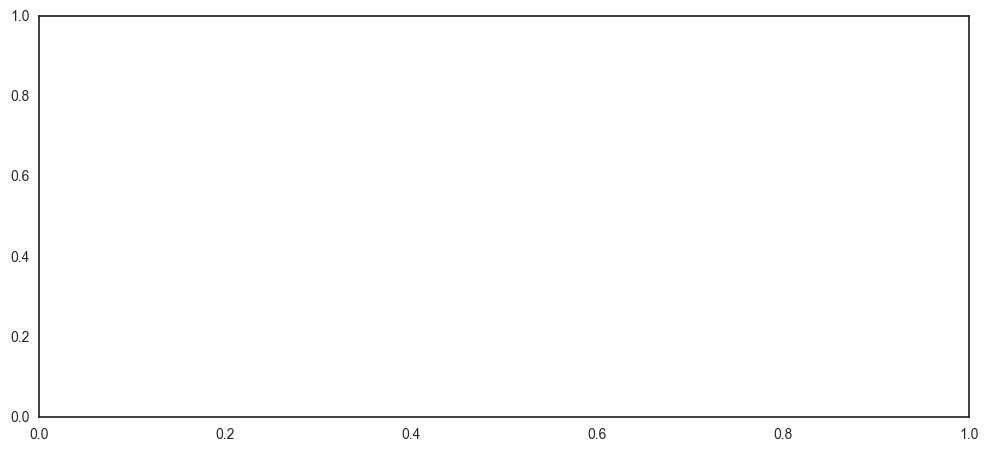

In [15]:
fig= plt.figure(1)
fig.set_size_inches(12.0, 30.0)
plt.style.use('seaborn-white')



for i, lambda_var in enumerate(array_temp): 
    ax = plt.subplot(5,1,i+1)
    solver = Solver(X=X, U=U_init, kernel=kern_array[i], U_ref= U, \
                    noise_interval = noise_interval, add_reg = add_reg, lambda_var = lambda_var, eta=eta)
    hist_nll_eu, hist_eta, hist_kern_eu, hist_Hsig_eu = \
                      solver.optimize(max_iters = max_iters, stepsize_mode= stepsize_mode, optimizor = "gd")
    solver_array.append(solver)
    hist_cond2K_array.append(solver.hist_T_norm)
    hist_condK_array.append(solver.hist_cond_K)
    hist_nll_eu_array.append(hist_nll_eu)
    hist_kern_eu_array.append(hist_kern_eu)
    
    
    solver2 = Solver(X=X, U=U_init, kernel=kern_grass_array[i], U_ref = U, \
                     noise_interval = noise_interval, add_reg = add_reg, lambda_var = lambda_var, eta=eta)
    hist_nll_grass, hist_eta, hist_kern_grass, hist_Hsig_grass = \
                      solver2.optimize(max_iters = max_iters, stepsize_mode= stepsize_mode, optimizor = "gd_grass")
    hist_Hsig_array.append(hist_Hsig_grass)
    hist_Gnorm_array.append(solver2.hist_G_norm)
    hist_cond2K_grass_array.append(solver2.hist_T_norm)
    hist_condK_grass_array.append(solver2.hist_cond_K)
    hist_kern_grass_dU_array.append(solver2.hist_update) 
    
    solver_array.append(solver2)
    hist_nll_grass_array.append(hist_nll_grass)
    hist_kern_grass_array.append(hist_kern_grass)
    
    solver3 = Solver(X=X, U=U_init, kernel=kern_conjugate_grass_array[i], U_ref = U, \
                     noise_interval = noise_interval, add_reg = add_reg, lambda_var = lambda_var, eta=eta)
    hist_nll_grass2, hist_eta2, hist_kern_grass2, hist_Hsig_grass2 = \
                      solver3.optimize(max_iters = max_iters, stepsize_mode= stepsize_mode, optimizor = "cg_grass")
    hist_Hsig_conjugate_array.append(hist_Hsig_grass2)    
    hist_Gnorm_conjugate_array.append(solver3.hist_G_norm)   
    hist_deltaG_array.append(solver3.hist_delta_G)
    hist_gamma_array.append(solver3.hist_gamma)
    hist_cond2K_conjugate_array.append(solver3.hist_T_norm)
    hist_condK_conjugate_array.append(solver3.hist_cond_K)
    hist_kern_grass2_dU_array.append(solver3.hist_update) 
        
    solver_array.append(solver3)
    hist_nll_conjugate_grass_array.append(hist_nll_grass2)
    hist_kern_grass2_array.append(hist_kern_grass2)
    
    %xdel solver
    %xdel solver2
    %xdel solver3

In [16]:
hist_nll_eu_array

[array([  66.37060776,   64.80569984,   64.85583251,   64.90736631,
          64.42072218,   63.8343322 ,   63.34504837,   62.90202675,
          62.47068646,   62.0532321 ,   61.6648687 ,   61.32253273,
          61.03933935,   60.81885322,   60.65411757,   60.53220166,
          60.44029313,   60.36843292,   60.31018186,   60.26150588,
          60.21983793,   60.18193378,   60.15110443,   60.12504578,
          60.10050055,   60.08142778,   60.06565414,   60.05230858,
          60.03728975,   60.02904282,   60.02285602,   60.01837129,
          60.01499151,   60.01219325,   60.01422463,   60.01045047,
          60.01274027,   60.0110342 ,   60.00820445,   60.00404699,
          59.99847267,   59.99148976,   59.98313629,   59.97352876,
          59.96286305,   59.95125997,   59.93891748,   59.9259893 ,
          59.91261771,   59.89900012,   59.88520427,   59.87139034,
          59.85764701,   59.84405285,   59.83067244,   59.8176191 ,
          59.80493246,   59.79264911,   59.78080

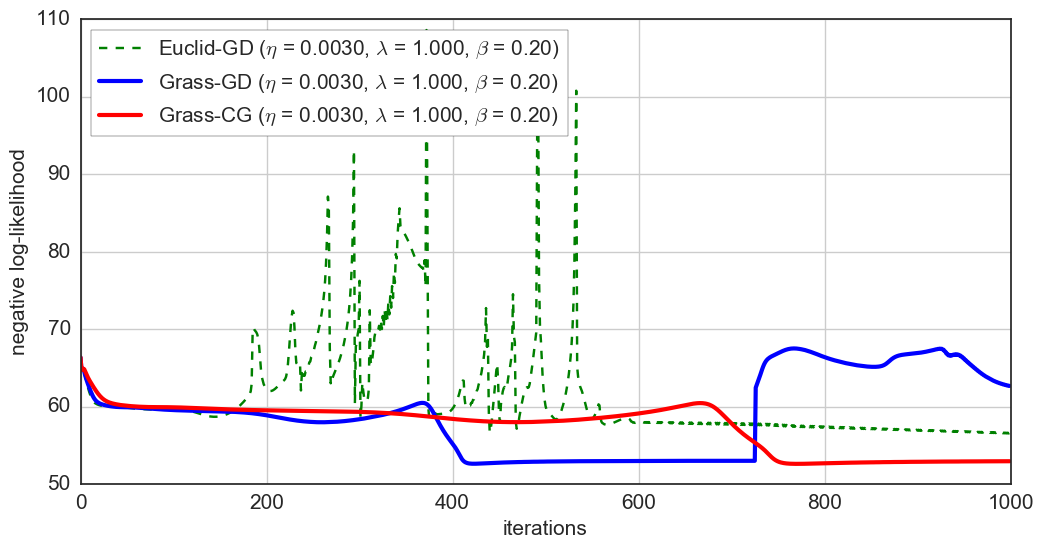

In [17]:
fig= plt.figure(1)
fig.set_size_inches(12.0, 6.0*len(array_temp))
plt.style.use('seaborn-white')

for i, lambda_var in enumerate(array_temp):
    ax = plt.subplot(len(array_temp),1,i+1)
    h1, = plt.plot(np.arange(max_iters), hist_nll_eu_array[i], '--g')
    h2, = plt.plot(np.arange(max_iters), hist_nll_grass_array[i], '-b', linewidth=3.0)
    h3, = plt.plot(np.arange(max_iters), hist_nll_conjugate_grass_array[i], '-r', linewidth=3.0)

    if add_reg:
        ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                                 .format(eta, lambda_var, noise_interval[0]), \
                                 r"Grass-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                                 .format(eta, lambda_var, noise_interval[0]), \
                                 r"Grass-CG ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                                 .format(eta, lambda_var, noise_interval[0])], \
                                 fontsize = 15, loc='upper left', frameon=True)
    else:    
        ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:6.5f})".format(eta), r"Grass-GD ($\eta$ = {0:6.5f})".format(eta), \
                                 r"Grass-CG ($\eta$ = {0:6.5f})".format(eta)], \
                             fontsize = 15, loc='upper left', frameon=True)
    plt.grid(1)
    plt.ylabel('negative log-likelihood', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    #ax.set_ylim([50, 120])
plt.show    
if Ifsavefig:
    file_org = "../figures/04_21_16_" + str(trial) + "_"
    file_tail = "_nll_iters_GrassCG_GD_EuGD.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

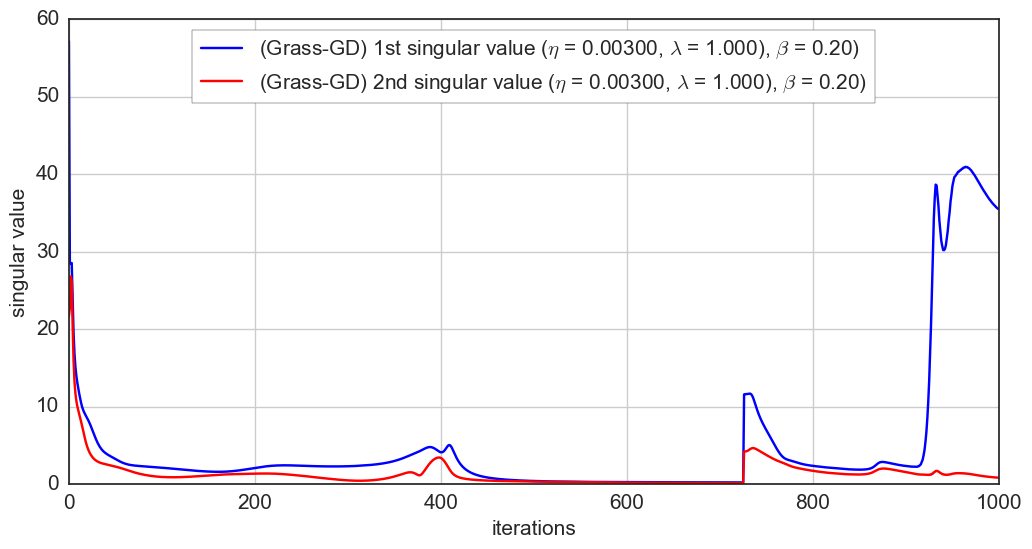

In [18]:
fig= plt.figure(2)
fig.set_size_inches(12.0, 6.0*len(array_temp))
plt.style.use('seaborn-white')

for i, lambda_var in enumerate(array_temp):
    ax = plt.subplot(len(array_temp),1,i+1)
    h1, = plt.plot(np.arange(max_iters), hist_Hsig_array[i][:,0], 'b')
    h2, = plt.plot(np.arange(max_iters), hist_Hsig_array[i][:,1], 'r')
    if add_reg:
        ax.legend([h1, h2], [r"(Grass-GD) 1st singular value ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f}), $\beta$ = {2:3.2f})"\
                             .format(eta, lambda_var, noise_interval[0]), \
                             r"(Grass-GD) 2nd singular value ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f}), $\beta$ = {2:3.2f})"\
                             .format(eta, lambda_var, noise_interval[0])], \
                             fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"1st singular value ($\eta$ = {0:6.5f})".format(eta), r"2nd singular value ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel('singular value', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_21_16_" + str(trial) + "_"
    file_tail = "_sig_iters_Grass_GD.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

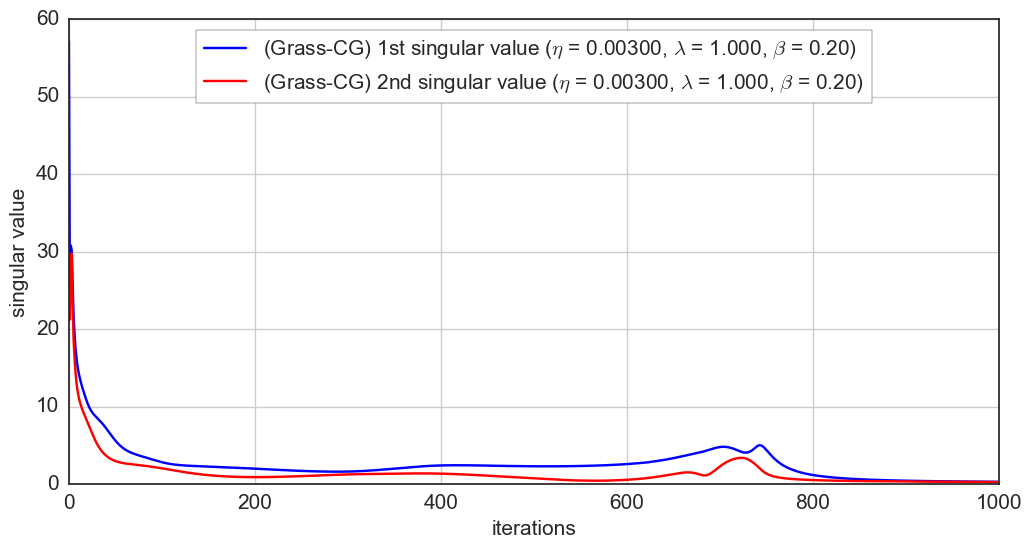

In [19]:
fig= plt.figure(3)
fig.set_size_inches(12.0, 6.0*len(array_temp))
plt.style.use('seaborn-white')

for i, lambda_var in enumerate(array_temp):
    ax = plt.subplot(len(array_temp),1,i+1)
    h1, = plt.plot(np.arange(max_iters), hist_Hsig_conjugate_array[i][:,0], 'b')
    h2, = plt.plot(np.arange(max_iters), hist_Hsig_conjugate_array[i][:,1], 'r')
    if add_reg:
        ax.legend([h1, h2], [r"(Grass-CG) 1st singular value ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                             .format(eta, lambda_var, noise_interval[0]), \
                             r"(Grass-CG) 2nd singular value ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                             .format(eta, lambda_var, noise_interval[0])], \
                             fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"1st singular value ($\eta$ = {0:6.5f})".format(eta), r"2nd singular value ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel('singular value', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.set_ylim([0,60])
plt.show    
if Ifsavefig:
    file_org = "../figures/04_21_16_" + str(trial) + "_"
    file_tail = "_sig_iters_Grass_CG.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

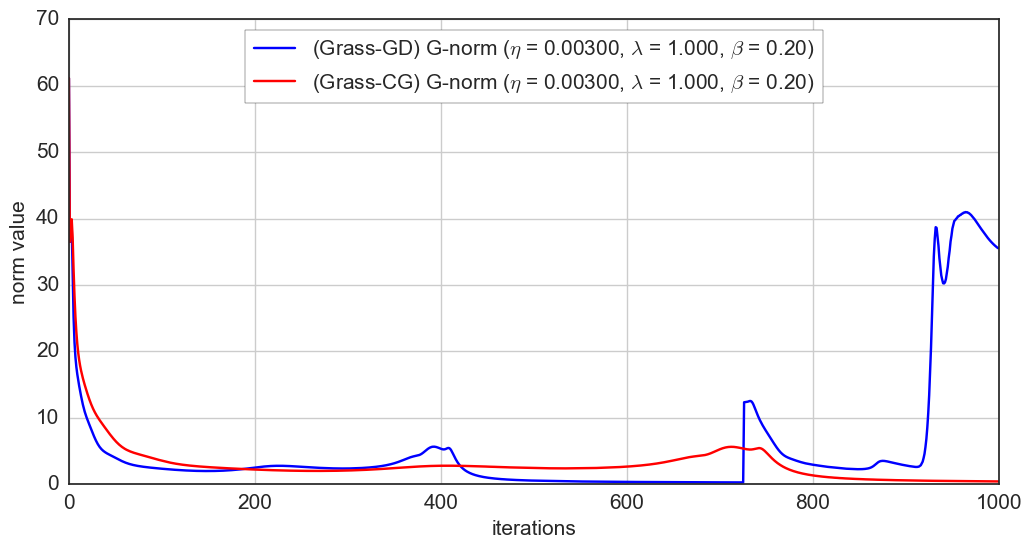

In [20]:
fig= plt.figure(4)
fig.set_size_inches(12.0, 6.0*len(array_temp))
plt.style.use('seaborn-white')

for i, lambda_var in enumerate(array_temp):
    ax = plt.subplot(len(array_temp),1,i+1)
    h1, = plt.plot(np.arange(max_iters), hist_Gnorm_array[i], 'b')
    h2, = plt.plot(np.arange(max_iters), hist_Gnorm_conjugate_array[i], 'r')
    if add_reg:
        ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                             .format(eta, lambda_var, noise_interval[0]), \
                             r"(Grass-CG) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                             .format(eta, lambda_var, noise_interval[0])], \
                             fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f})".format(eta), r"(Grass-CG) G-norm ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel('norm value', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_21_16_" + str(trial) + "_"
    file_tail = "_sig_iters_Gnorm_GDCG.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

In [21]:
len(hist_gamma_array[i])

1000

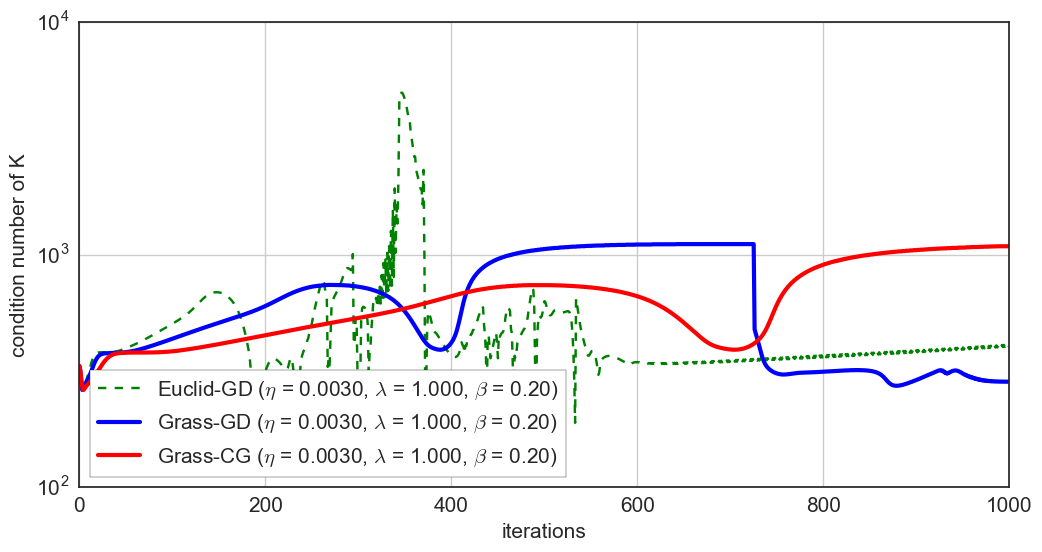

In [22]:
fig= plt.figure(5)
fig.set_size_inches(12.0, 6.0*len(array_temp))
plt.style.use('seaborn-white')

for i, lambda_var in enumerate(array_temp):
    ax = plt.subplot(len(array_temp),1,i+1)
    h1, = plt.semilogy(np.arange(max_iters), hist_condK_array[i], '--g')
    h2, = plt.semilogy(np.arange(max_iters), hist_condK_grass_array[i], '-b', linewidth=3.0)
    h3, = plt.semilogy(np.arange(max_iters), hist_condK_conjugate_array[i], '-r', linewidth=3.0)

    if add_reg:
         ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                                  .format(eta, lambda_var, noise_interval[0]), \
                                  r"Grass-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                                  .format(eta, lambda_var, noise_interval[0]), \
                                  r"Grass-CG ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                                  .format(eta, lambda_var, noise_interval[0])], \
                             fontsize = 15, loc='lower left', frameon=True)
    else:    
        ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:6.5f})".format(eta), r"Grass-GD ($\eta$ = {0:6.5f})".format(eta), \
                                 r"Grass-CG ($\eta$ = {0:6.5f})".format(eta)], \
                             fontsize = 15, loc='upper left', frameon=True)
    plt.grid(1)
    plt.ylabel('condition number of K', fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_21_16_" + str(trial) + "_"
    file_tail = "_condK_iters.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

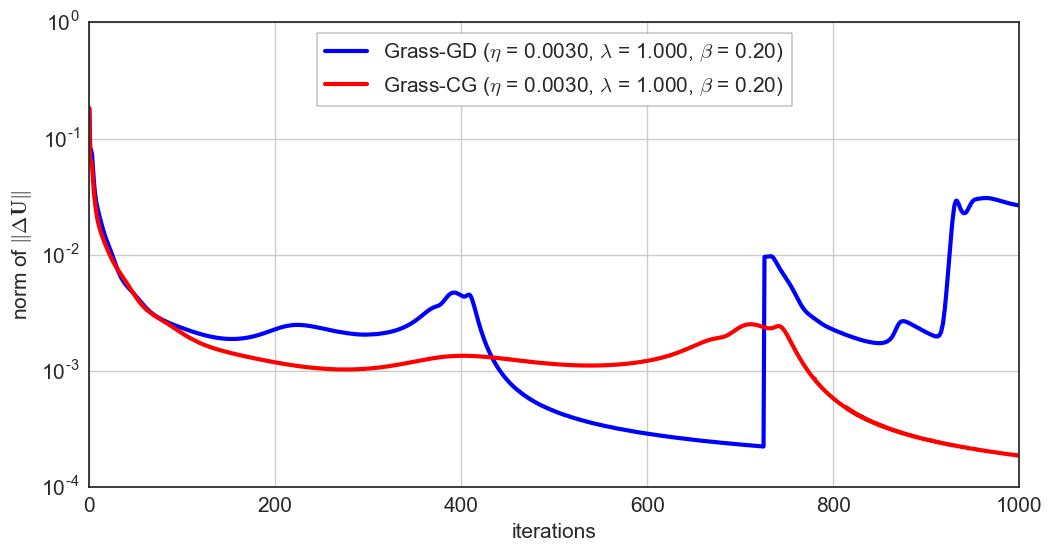

In [23]:
fig= plt.figure(6)
fig.set_size_inches(12.0, 6.0*len(array_temp))
plt.style.use('seaborn-white')

for i, lambda_var in enumerate(array_temp):
    ax = plt.subplot(len(array_temp),1,i+1)
    h1, = plt.semilogy(np.arange(max_iters), hist_kern_grass_dU_array[i], '-b', linewidth=3.0)
    h2, = plt.semilogy(np.arange(max_iters), hist_kern_grass2_dU_array[i], '-r', linewidth=3.0)

    if add_reg:
         ax.legend([h1, h2], [r"Grass-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                                  .format(eta, lambda_var, noise_interval[0]), \
                                  r"Grass-CG ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                                  .format(eta, lambda_var, noise_interval[0])], \
                             fontsize = 15, loc='upper center', frameon=True)
        #ax.legend([h3], [r"Conjugate Grassmann ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
        #                     fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"Grass-GD ($\eta$ = {0:6.5f})".format(eta), \
                                 r"Grass-CG ($\eta$ = {0:6.5f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel(r"norm of $\|\Delta \mathbf{U}\|$", fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_21_16_" + str(trial) + "_"
    file_tail = "_orth_iters.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

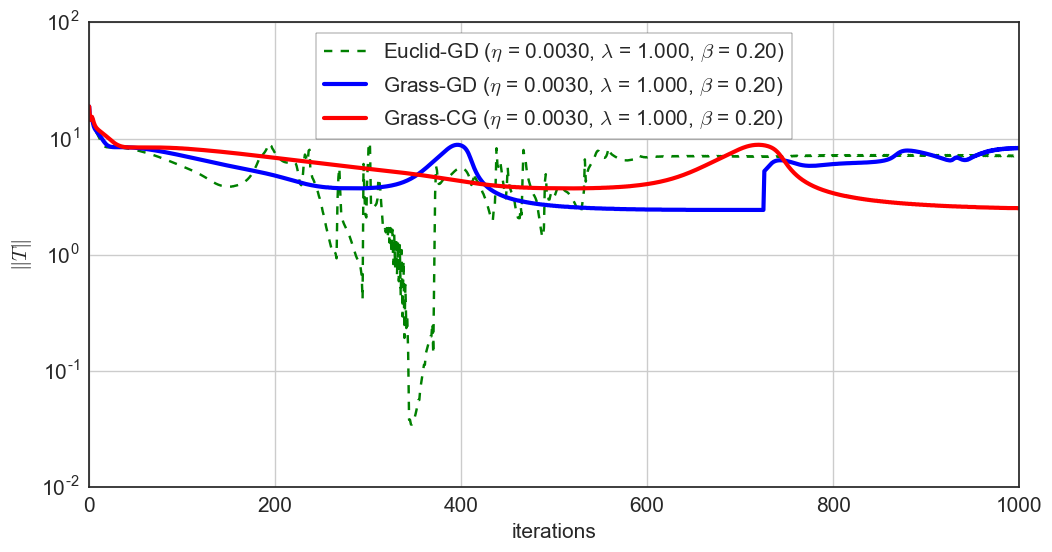

In [24]:
fig= plt.figure(1)
fig.set_size_inches(12.0, 6.0*len(array_temp))
plt.style.use('seaborn-white')

for i, lambda_var in enumerate(array_temp):
    ax = plt.subplot(len(array_temp),1,i+1)
    h1, = plt.semilogy(np.arange(max_iters), hist_cond2K_array[i], '--g')
    h2, = plt.semilogy(np.arange(max_iters), hist_cond2K_grass_array[i], '-b', linewidth=3.0)
    h3, = plt.semilogy(np.arange(max_iters), hist_cond2K_conjugate_array[i], '-r', linewidth=3.0)

    if add_reg:
         ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                                  .format(eta, lambda_var, noise_interval[0]), \
                                  r"Grass-GD ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                                  .format(eta, lambda_var, noise_interval[0]), \
                                  r"Grass-CG ($\eta$ = {0:5.4f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                                  .format(eta, lambda_var, noise_interval[0])], \
                             fontsize = 15, loc='upper center', frameon=True)
        #ax.legend([h3], [r"Conjugate Grassmann ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
        #                     fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2, h3], [r"Euclid-GD ($\eta$ = {0:6.5f})".format(eta), r"Grass-GD ($\eta$ = {0:6.5f})".format(eta), \
                                 r"Grass-CG ($\eta$ = {0:6.5f})".format(eta)], \
                             fontsize = 15, loc='upper center', frameon=True)
    plt.grid(1)
    plt.ylabel(r"$\|T\|$", fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_21_16_" + str(trial) + "_"
    file_tail = "_cond2K_iters.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

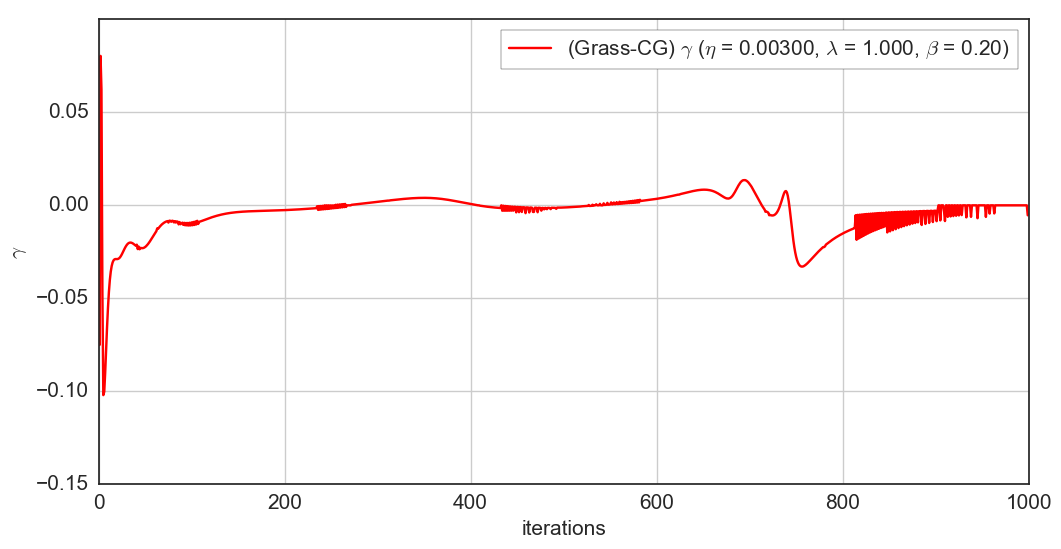

In [25]:
fig= plt.figure(5)
fig.set_size_inches(12.0, 6.0*len(array_temp))
plt.style.use('seaborn-white')

for i, lambda_var in enumerate(array_temp):
    ax = plt.subplot(len(array_temp),1,i+1)
    #h1, = plt.plot(np.arange(max_iters), hist_Gnorm_array[i], 'b')
    h1, = plt.plot(np.arange(max_iters), hist_gamma_array[i], 'r')
    if add_reg:
        ax.legend([h1], [r"(Grass-CG) $\gamma$ ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                         .format(eta, lambda_var, noise_interval[0])], \
                             fontsize = 15, loc='upper right', frameon=True)
        #ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
        #                     r"(Grass-CG) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
        #                     fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f})".format(eta), r"(Grass-CG) G-norm ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='lower center', frameon=True)
    plt.grid(1)
    plt.ylabel(r"$\gamma$", fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_20_16_" + str(trial) + "_"
    file_tail = "_gamma_iters_CG.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

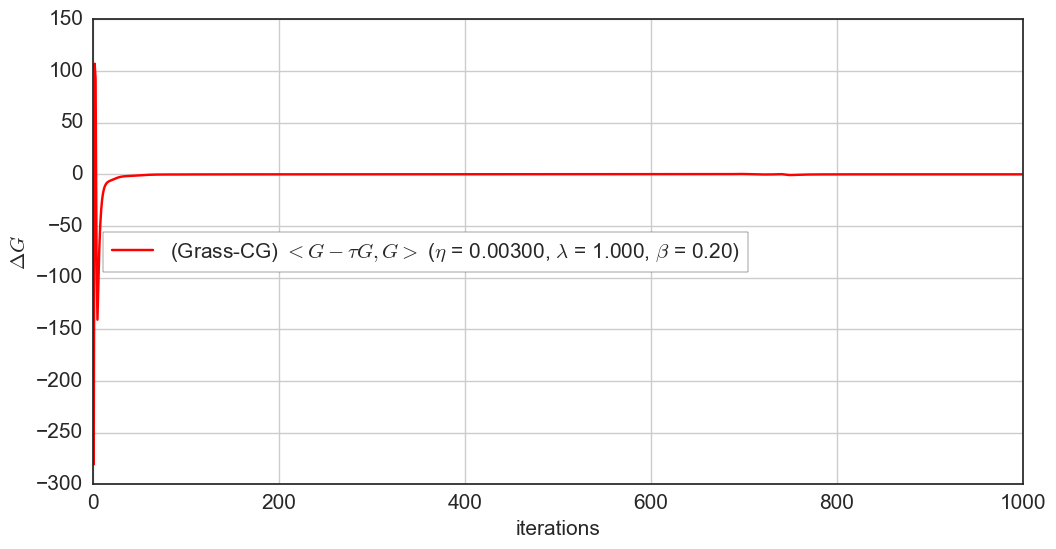

In [26]:
fig= plt.figure(6)
fig.set_size_inches(12.0, 6.0*len(array_temp))
plt.style.use('seaborn-white')

for i, lambda_var in enumerate(array_temp):
    ax = plt.subplot(len(array_temp),1,i+1)
    #h1, = plt.plot(np.arange(max_iters), hist_Gnorm_array[i], 'b')
    h1, = plt.plot(np.arange(max_iters), hist_deltaG_array[i], 'r')
    if add_reg:
        ax.legend([h1], [r"(Grass-CG) $<G - \tau G, G>$ ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                         .format(eta, lambda_var, noise_interval[0])], \
                             fontsize = 15, loc='center left', frameon=True)
        #ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i]), \
        #                     r"(Grass-CG) G-norm ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f})".format(eta, lambda_array[i])], \
        #                     fontsize = 15, loc='upper center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"(Grass-GD) G-norm ($\eta$ = {0:6.5f})".format(eta), r"(Grass-CG) G-norm ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='lower center', frameon=True)
    plt.grid(1)
    plt.ylabel(r"$\Delta G$", fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
plt.show    
if Ifsavefig:
    file_org = "../figures/04_21_16_" + str(trial) + "_"
    file_tail = "_dG_iters_CG.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  

In [27]:
hist_Gnorm_conjugate_array[0][np.where(hist_deltaG_array[0]>1e4)]

array([], dtype=float64)

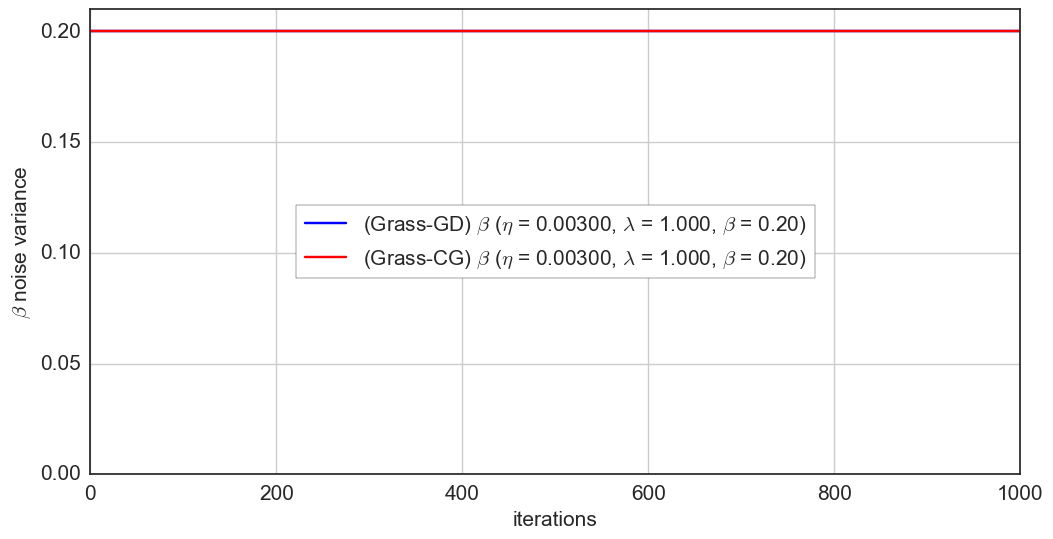

In [28]:
fig= plt.figure(6)
fig.set_size_inches(12.0, 6.0*len(array_temp))
plt.style.use('seaborn-white')

for i, lambda_var in enumerate(array_temp):
    ax = plt.subplot(len(array_temp),1,i+1)
    #h1, = plt.plot(np.arange(max_iters), hist_Gnorm_array[i], 'b')
    h1, = plt.plot(np.arange(max_iters), hist_kern_grass_array[i][:,2], 'b')
    h2, = plt.plot(np.arange(max_iters), hist_kern_grass2_array[i][:,2], 'r')
    if add_reg:
        ax.legend([h1, h2], [r"(Grass-GD) $\beta$ ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                             .format(eta, lambda_var, noise_interval[0]), \
                             r"(Grass-CG) $\beta$ ($\eta$ = {0:6.5f}, $\lambda$ = {1:5.3f}, $\beta$ = {2:3.2f})"\
                             .format(eta, lambda_var,noise_interval[0])], \
                             fontsize = 15, loc='center', frameon=True)
    else:    
        ax.legend([h1, h2], [r"(Grass-GD) $\beta$ ($\eta$ = {0:6.5f})".format(eta), r"(Grass-CG) $\beta$ ($\eta$ = {0:5.4f})".format(eta)], \
                             fontsize = 15, loc='lower center', frameon=True)
    plt.grid(1)
    plt.ylabel(r"$\beta$ noise variance", fontsize = 15)
    plt.xlabel('iterations', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.set_ylim([0,noise_interval[1]])
plt.show    
if Ifsavefig:
    file_org = "../figures/04_21_16_" + str(trial) + "_"
    file_tail = "_beta_iters.eps"
    if choice == "random":
        file_comment = "rand"
    elif choice == "near":
        file_comment = "near"
        
    if add_reg:
        file_comment = file_comment +'Reg'
        
    fig.savefig(file_org + file_comment + file_tail )  